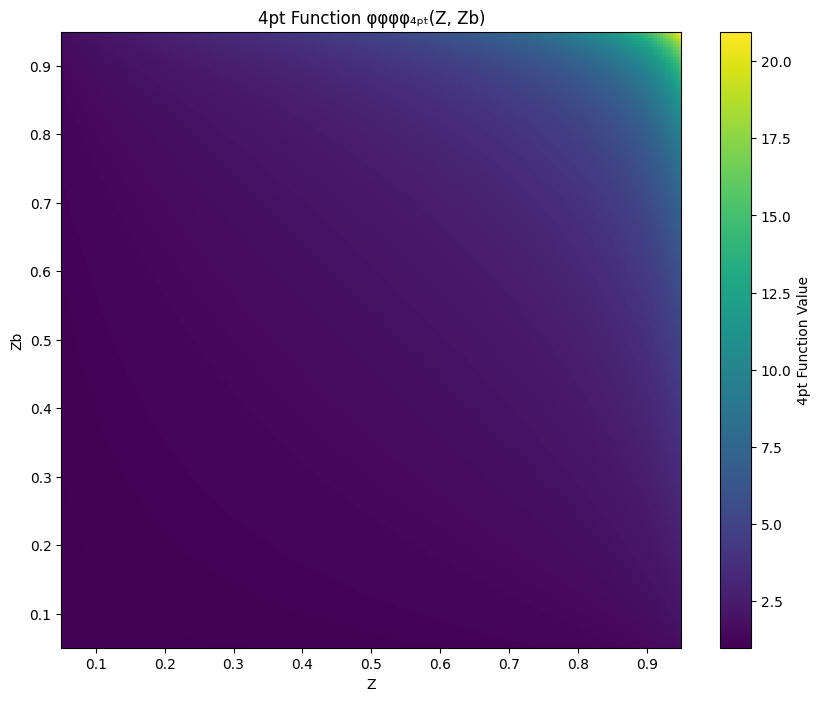

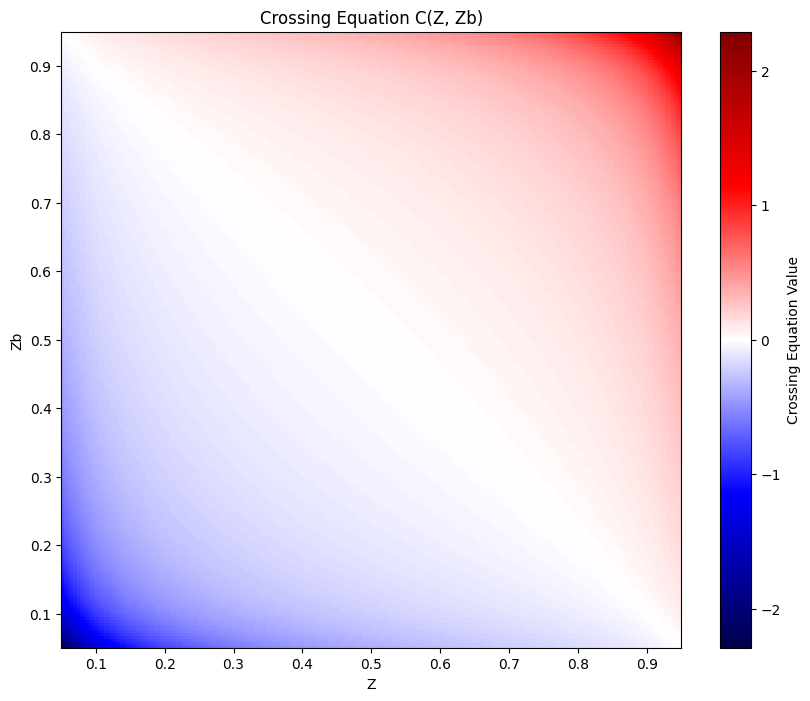

In [5]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read and Preprocess the 4pt Function
file_path = '/Users/justinas/Dropbox/MachineLearningCFT/Ning/Ising_4pt.txt'
try:
    with open(file_path, 'r') as f:
        expr_str = f.read()
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the file path.")
    exit()

# Replace Mathematica's scientific notation '*^' with Python's 'e'
expr_str = expr_str.replace('*^', 'e')

# Replace exponentiation '^' with Python's '**'
expr_str = expr_str.replace('^', '**')

# Remove any newline characters
expr_str = expr_str.replace('\n', ' ')

# Step 2: Parse the Expression with sympy
# Define symbolic variables
Z, Zb = sp.symbols('Z Zb')

# Parse the expression string into a sympy expression
try:
    expr = sp.sympify(expr_str, locals={'Z': Z, 'Zb': Zb})
except Exception as e:
    print(f"An error occurred during parsing: {e}")
    exit()

# Define the 4pt function
phi4pt = expr

# Step 3: Convert phi4pt into a numerical function
phi4pt_func = sp.lambdify((Z, Zb), phi4pt, modules='numpy')

# Step 4: Create a Grid for Z and Zb between 0.05 and 0.95
Z_vals = np.linspace(0.05, 0.95, 200)
Zb_vals = np.linspace(0.05, 0.95, 200)
Z_grid, Zb_grid = np.meshgrid(Z_vals, Zb_vals)

# Step 5: Evaluate the 4pt Function
try:
    phi4pt_grid = phi4pt_func(Z_grid, Zb_grid)
except Exception as e:
    print(f"An error occurred during function evaluation: {e}")
    exit()

# Handle infinities or NaNs if they occur
phi4pt_grid = np.nan_to_num(phi4pt_grid, nan=np.nan, posinf=np.nan, neginf=np.nan)

# Step 6: Plot the 4pt Function
plt.figure(figsize=(10, 8))
plt.imshow(phi4pt_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='4pt Function Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('4pt Function φφφφ₄ₚₜ(Z, Zb)')
plt.show()

# Step 7: Define Delta_phi
Delta_phi_value = 0.5  # You can change this value as needed

# Step 8: Compute the Crossing Equation Numerically
def crossing_func_num(Z_vals, Zb_vals):
    term1 = (Z_vals * Zb_vals)**(-Delta_phi_value) * phi4pt_func(Z_vals, Zb_vals)
    term2 = ((1 - Z_vals) * (1 - Zb_vals))**(-Delta_phi_value) * phi4pt_func(1 - Z_vals, 1 - Zb_vals)
    return term1 - term2

try:
    C_grid = crossing_func_num(Z_grid, Zb_grid)
except Exception as e:
    print(f"An error occurred during function evaluation: {e}")
    exit()

# Handle infinities or NaNs if they occur
C_grid = np.nan_to_num(C_grid, nan=np.nan, posinf=np.nan, neginf=np.nan)

# Step 9: Plot the Crossing Equation
plt.figure(figsize=(10, 8))
plt.imshow(C_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic', vmin=-np.nanmax(np.abs(C_grid)), vmax=np.nanmax(np.abs(C_grid)))
plt.colorbar(label='Crossing Equation Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Crossing Equation C(Z, Zb)')
plt.show()


In [6]:
import torch
import torch.nn as nn
from torch import autograd
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import KAN module (assuming it's available)
from kan import KAN  # Ensure that 'kan' is installed or available in your PYTHONPATH

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')



Using device: cpu


In [273]:
# File path to your 4pt function
file_path = '/Users/justinas/Dropbox/MachineLearningCFT/Ning/Ising_4pt.txt'
file_path = 'test_fn.txt'
# Read and preprocess the 4pt function

with open(file_path, 'r') as f:
    expr_str = f.read()

# Replace Mathematica's notation with Python's notation
expr_str = expr_str.replace('*^', 'e')
expr_str = expr_str.replace('^', '**')
expr_str = expr_str.replace('\n', ' ')

# Define symbolic variables
Z_sym, Zb_sym = sp.symbols('Z Zb')

# Parse the expression string into a sympy expression
expr = sp.sympify(expr_str, locals={'Z': Z_sym, 'Zb': Zb_sym})

# Convert the sympy expression into a numerical function
phi4pt_func = sp.lambdify((Z_sym, Zb_sym), expr, modules='numpy')


In [278]:
# Define Delta_phi (scaling dimension)
Delta_phi = 0.5181489  # Adjust as needed

# Define the crossing equation function
def crossing_equation(Z, Zb, phi_func):
    term1 = (Z * Zb) ** (-Delta_phi) * phi_func(Z, Zb)
    term2 = ((1 - Z) * (1 - Zb)) ** (-Delta_phi) * phi_func(1 - Z, 1 - Zb)
    return term1 - term2


In [290]:
# Number of points
num_points = 1000

# Generate random points in [0, 1] x [0, 1]
Z_vals = np.random.uniform(0, 1, num_points)
Zb_vals = np.random.uniform(0, 1, num_points)
points = np.vstack((Z_vals, Zb_vals)).T


In [291]:
# Define Region A: Z and Zb between 0.2 and 0.8
mask_region_a = (Z_vals >= 0.2) & (Z_vals <= 0.8) & (Zb_vals >= 0.2) & (Zb_vals <= 0.8)
mask_region_b = ~mask_region_a  # Points outside Region A

# Points in Region A
points_a = points[mask_region_a]
Z_a = points_a[:, 0]
Zb_a = points_a[:, 1]

# Points in Region B
points_b = points[mask_region_b]
Z_b = points_b[:, 0]
Zb_b = points_b[:, 1]


In [292]:
# Convert to torch tensors
Z_a_tensor = torch.tensor(Z_a, dtype=torch.float32, device=device).unsqueeze(1)
Zb_a_tensor = torch.tensor(Zb_a, dtype=torch.float32, device=device).unsqueeze(1)
Z_b_tensor = torch.tensor(Z_b, dtype=torch.float32, device=device).unsqueeze(1)
Zb_b_tensor = torch.tensor(Zb_b, dtype=torch.float32, device=device).unsqueeze(1)


In [293]:
# Compute the 4pt function values at points in Region A
phi4pt_a = phi4pt_func(Z_a, Zb_a)
phi4pt_a_tensor = torch.tensor(phi4pt_a, dtype=torch.float32, device=device).unsqueeze(1)


In [294]:
# Define the loss function for Region A
def loss_region_a(model_output, target_output):
    return torch.mean((model_output - target_output) ** 2)

# Define the loss function for Region B
def loss_region_b(crossing_values):
    return torch.mean(crossing_values ** 2)


# Total loss function
def total_loss(model, Z_a, Zb_a, phi4pt_a, Z_b, Zb_b,weight_a,weight_b):
    # Predictions in Region A
    inputs_a = torch.cat([Z_a, Zb_a], dim=1)
    outputs_a = model(inputs_a)
    loss_a = loss_region_a(outputs_a, phi4pt_a)

    # Predictions in Region B
    inputs_b = torch.cat([Z_b, Zb_b], dim=1)
    outputs_b = model(inputs_b)

    # Compute crossing equation values for outputs_b
    phi_func_model = lambda Z, Zb: model(torch.cat([Z, Zb], dim=1))
    crossing_b = crossing_equation(Z_b, Zb_b, phi_func_model)
    loss_b = loss_region_b(crossing_b)

    # Total loss
    return weight_a * loss_a + weight_b * loss_b, loss_a, loss_b


In [284]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of training epochs
num_epochs = 10000



def train(model,num_epochs,weight_a=1.0,weight_b=1.0):
    # Training loop
    for epoch in tqdm(range(num_epochs), desc='Training'):
        optimizer.zero_grad()

        # Compute total loss
        loss_total, loss_a_value, loss_b_value = total_loss(
            model,
            Z_a_tensor, Zb_a_tensor, phi4pt_a_tensor,
            Z_b_tensor, Zb_b_tensor,
            weight_a,weight_b
        )

        # Backpropagation
        loss_total.backward()
        optimizer.step()

        # Print losses every 100 epochs
        if epoch % (num_epochs/10) == 0:
            print(f'Epoch {epoch}: Total Loss = {loss_total.item():.6f}, '
                f'Loss A = {loss_a_value.item():.6f}, Loss B = {loss_b_value.item():.6f}')


In [168]:
train(model,100)

Training:   2%|▏         | 2/100 [00:00<00:18,  5.30it/s]

Epoch 0: Total Loss = 4.314510, Loss A = 4.187815, Loss B = 0.126695


Training:  11%|█         | 11/100 [00:02<00:19,  4.59it/s]

Epoch 10: Total Loss = 4.314510, Loss A = 4.187815, Loss B = 0.126695


Training:  21%|██        | 21/100 [00:04<00:17,  4.58it/s]

Epoch 20: Total Loss = 4.314510, Loss A = 4.187815, Loss B = 0.126695


Training:  31%|███       | 31/100 [00:06<00:14,  4.73it/s]

Epoch 30: Total Loss = 4.314510, Loss A = 4.187815, Loss B = 0.126695


Training:  41%|████      | 41/100 [00:08<00:12,  4.77it/s]

Epoch 40: Total Loss = 4.314510, Loss A = 4.187815, Loss B = 0.126695


Training:  42%|████▏     | 42/100 [00:09<00:12,  4.56it/s]


KeyboardInterrupt: 

In [147]:
train(100,1.0,1.0)

Training:   1%|          | 1/100 [00:00<00:22,  4.43it/s]

Epoch 0: Total Loss = 3.475555, Loss A = 3.387991, Loss B = 0.087564


Training:  11%|█         | 11/100 [00:02<00:21,  4.14it/s]

Epoch 10: Total Loss = 3.251730, Loss A = 3.170239, Loss B = 0.081492


Training:  21%|██        | 21/100 [00:04<00:16,  4.72it/s]

Epoch 20: Total Loss = 2.976425, Loss A = 2.895284, Loss B = 0.081141


Training:  31%|███       | 31/100 [00:06<00:14,  4.84it/s]

Epoch 30: Total Loss = 2.671982, Loss A = 2.585922, Loss B = 0.086059


Training:  41%|████      | 41/100 [00:09<00:12,  4.80it/s]

Epoch 40: Total Loss = 2.357260, Loss A = 2.260511, Loss B = 0.096749


Training:  51%|█████     | 51/100 [00:11<00:12,  3.83it/s]

Epoch 50: Total Loss = 2.043909, Loss A = 1.938218, Loss B = 0.105691


Training:  61%|██████    | 61/100 [00:13<00:08,  4.55it/s]

Epoch 60: Total Loss = 1.741515, Loss A = 1.624729, Loss B = 0.116786


Training:  71%|███████   | 71/100 [00:15<00:06,  4.65it/s]

Epoch 70: Total Loss = 1.465931, Loss A = 1.326335, Loss B = 0.139596


Training:  81%|████████  | 81/100 [00:17<00:04,  4.54it/s]

Epoch 80: Total Loss = 1.242063, Loss A = 1.068488, Loss B = 0.173576


Training:  91%|█████████ | 91/100 [00:20<00:02,  4.46it/s]

Epoch 90: Total Loss = 1.076734, Loss A = 0.870224, Loss B = 0.206510


Training: 100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


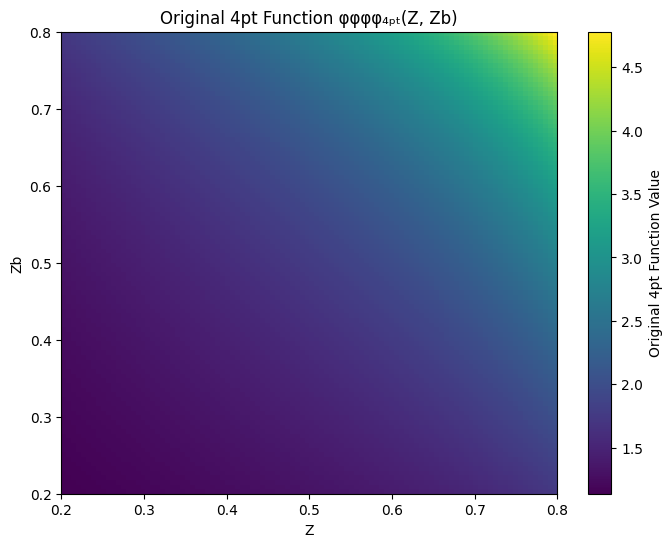

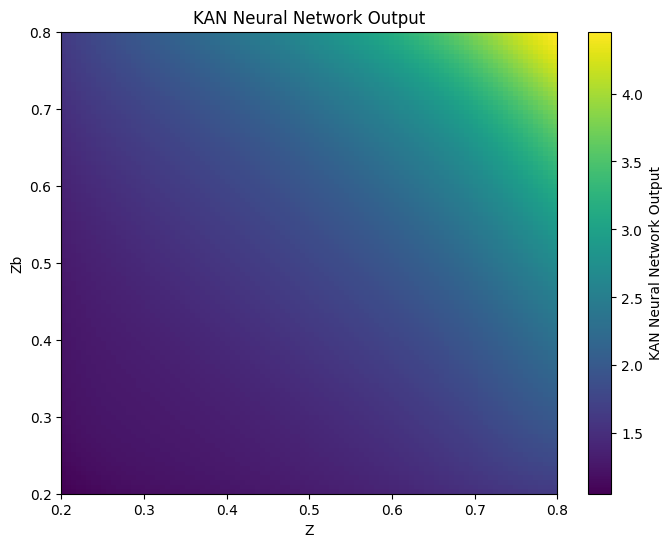

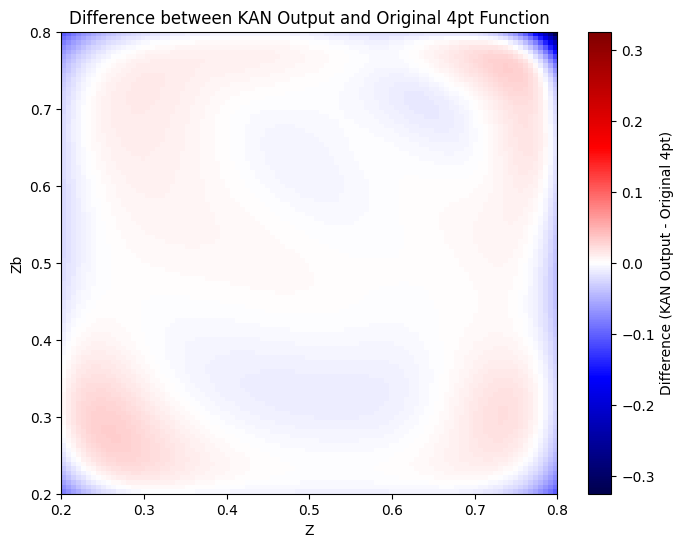

In [105]:
# Assuming the necessary imports and variables from previous code are already in place
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the grid for plotting
grid_size = 100
Z_plot = np.linspace(0.2, .8, grid_size)
Zb_plot = np.linspace(.2, .8, grid_size)
Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
Z_flat = Z_grid.flatten()
Zb_flat = Zb_grid.flatten()

# Convert grid points to tensors
Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device).unsqueeze(1)
Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device).unsqueeze(1)

# Evaluate the original 4pt function on the grid
phi4pt_values = phi4pt_func(Z_flat, Zb_flat)
phi4pt_grid = phi4pt_values.reshape(grid_size, grid_size)

# Evaluate the KAN model output on the grid
with torch.no_grad():
    inputs_plot = torch.cat([Z_tensor, Zb_tensor], dim=1)
    outputs_plot = model(inputs_plot).cpu().numpy().flatten()
outputs_plot_grid = outputs_plot.reshape(grid_size, grid_size)

# Compute the difference between the KAN output and the original 4pt function
difference_grid = outputs_plot_grid - phi4pt_grid

# Plot the original 4pt function
plt.figure(figsize=(8, 6))
plt.imshow(phi4pt_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Original 4pt Function Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Original 4pt Function φφφφ₄ₚₜ(Z, Zb)')
plt.show()

# Plot the KAN Neural Network Output
plt.figure(figsize=(8, 6))
plt.imshow(outputs_plot_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='KAN Neural Network Output')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('KAN Neural Network Output')
plt.show()

# Plot the Difference between KAN Output and Original 4pt Function
plt.figure(figsize=(8, 6))
plt.imshow(difference_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='seismic', 
           vmin=-np.max(np.abs(difference_grid)), vmax=np.max(np.abs(difference_grid)))
plt.colorbar(label='Difference (KAN Output - Original 4pt)')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Difference between KAN Output and Original 4pt Function')
plt.show()


In [53]:
Z_tensor.size( )

torch.Size([10000, 1])

In [62]:
Z_clamped.size()

torch.Size([10000, 1])

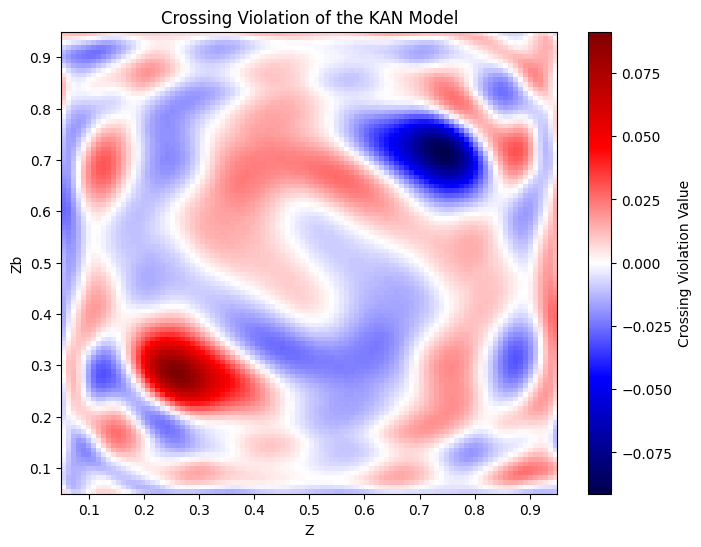

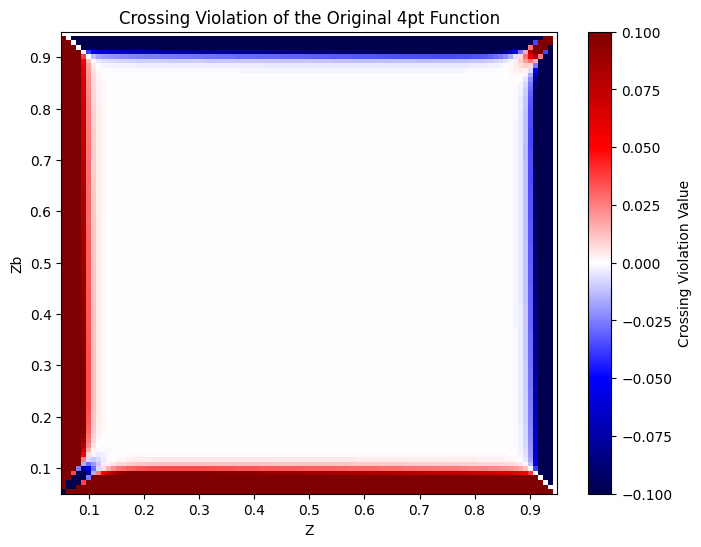

In [106]:
grid_size = 100
Z_plot = np.linspace(0.05, 0.95, grid_size)
Zb_plot = np.linspace(0.05, 0.95, grid_size)
Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
Z_flat = Z_grid.flatten()
Zb_flat = Zb_grid.flatten()

# Convert grid points to tensors
Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device).unsqueeze(1)
Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device).unsqueeze(1)

# Define phi_func to use the KAN model for predictions
def phi_func(Z, Zb):
    Z_tensor = torch.tensor(Z, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb, dtype=torch.float32, device=device).unsqueeze(1)
    inputs = torch.cat([Z_tensor, Zb_tensor], dim=1)
    with torch.no_grad():
        phi_values = model(inputs).cpu().numpy().flatten()
    return phi_values

# Compute the crossing equation values using the KAN model
epsilon = 1e-8  # Small constant to prevent division by zero
Z_np_clamped = np.clip(Z_flat, epsilon, 1 - epsilon)
Zb_np_clamped = np.clip(Zb_flat, epsilon, 1 - epsilon)

# Calculate the crossing violation
crossing_values = crossing_equation(Z_np_clamped, Zb_np_clamped, phi_func)

# Reshape crossing values for plotting
crossing_values_grid = crossing_values.reshape(grid_size, grid_size)

# Plot the crossing violation
plt.figure(figsize=(8, 6))
max_abs_crossing = np.max(np.abs(crossing_values))
plt.imshow(crossing_values_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
           vmin=-max_abs_crossing, vmax=max_abs_crossing)
plt.colorbar(label='Crossing Violation Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Crossing Violation of the KAN Model')
plt.show()

crossing_values = crossing_equation(Z_clamped, Zb_clamped, phi4pt_func)

# Reshape crossing values for plotting
crossing_values_grid = crossing_values.reshape(grid_size, grid_size)

# Plot the crossing violation
plt.figure(figsize=(8, 6))
max_abs_crossing = np.nanmax(np.abs(crossing_values))
plt.imshow(crossing_values_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
           vmin=-max_abs_crossing, vmax=max_abs_crossing)
plt.colorbar(label='Crossing Violation Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Crossing Violation of the Original 4pt Function')
plt.show()

In [47]:
crossing_values.size()

torch.Size([10000, 10000])

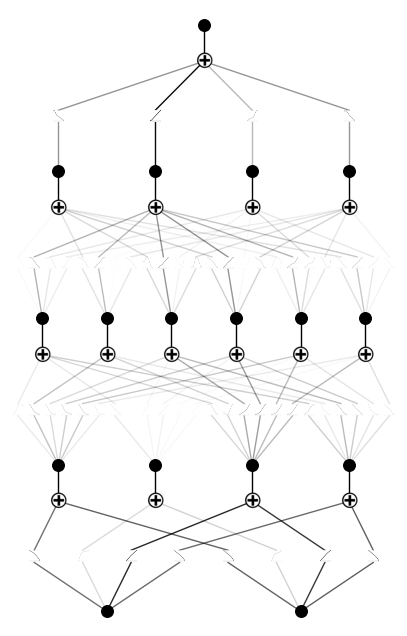

In [228]:
model.plot()

In [227]:
model.prune()

saving model version 0.1


MultKAN(
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)

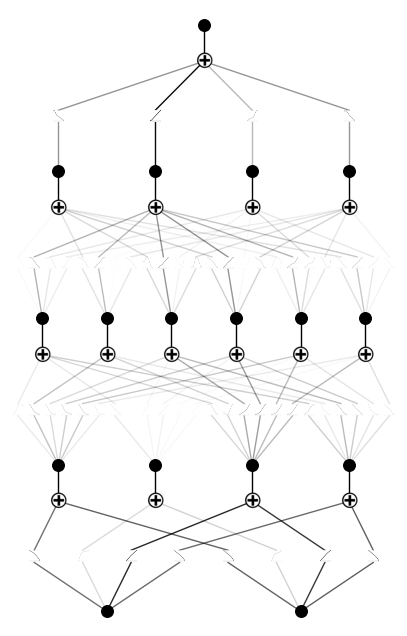

In [225]:
model.plot()

In [226]:
model.suggest_symbolic(0,1,0)

    function  fitting r2   r2 loss  complexity  complexity loss  total loss
0          x    0.988831 -6.483017           1                1   -0.496603
1      x^0.5    0.997285 -8.519438           2                2   -0.103888
2       sqrt    0.997285 -8.519438           2                2   -0.103888
3        log    0.996658 -8.220953           2                2   -0.044191
4  1/sqrt(x)    0.996447 -8.132678           2                2   -0.026536


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9888306260108948,
 1)

In [259]:
# Create powers of x list
lib = ['x'] + ['x^' + str(i) for i in range(2, 6)]  # Starts from x^2 to x^35

# Add the other functions
additional_funcs = ['exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']

# Combine powers of x with the additional functions
lib.extend(additional_funcs)
model.auto_symbolic(lib=lib)
model.symbolic_formula()

fixing (0,0,0) with x, r2=0.9924576282501221, c=1
fixing (0,0,1) with x, r2=0.993136465549469, c=1
fixing (0,0,2) with x, r2=0.9956589341163635, c=1
fixing (0,0,3) with x, r2=0.9024941325187683, c=1
fixing (0,1,0) with x, r2=0.9863204956054688, c=1
fixing (0,1,1) with x, r2=0.9871978759765625, c=1
fixing (0,1,2) with x, r2=0.9976246356964111, c=1
fixing (0,1,3) with exp, r2=0.9889224767684937, c=2
fixing (1,0,0) with sin, r2=0.9989435076713562, c=2
fixing (1,0,1) with x, r2=0.9691325426101685, c=1
fixing (1,0,2) with sin, r2=0.9885544180870056, c=2
fixing (1,0,3) with sin, r2=0.9977040886878967, c=2
fixing (1,0,4) with x, r2=0.04940921813249588, c=1
fixing (1,0,5) with x, r2=0.9506844282150269, c=1
fixing (1,1,0) with x, r2=0.8718829154968262, c=1
fixing (1,1,1) with x, r2=0.981122612953186, c=1
fixing (1,1,2) with x, r2=0.822019100189209, c=1
fixing (1,1,3) with x, r2=0.9135491251945496, c=1
fixing (1,1,4) with x, r2=0.9827836155891418, c=1
fixing (1,1,5) with x, r2=0.9470300674438477

([1.30644672904214*x_1 + 1.20326721141549*x_2 - 0.0110178550373975*(0.207797668239121*x_1 + 0.140157267696191*x_2 + 0.000407380937857385*exp(4.91759967803955*x_2) + 0.000129952859870742*exp(2.47954372633867*x_1 + 4.44831113306301*x_2) + 0.721777804787314*log(1.60913030392469*x_1 + 1.92679165313506*x_2 - 0.0011404981304369*exp(4.91759967803955*x_2) - 0.716288830820019*sin(1.5081522163604*x_1 + 1.37835278541891*x_2 + 1.15192933754594) + 2.56194019132772) + 0.145844437421187*sin(0.601320001421402*x_1 + 0.549567271722411*x_2 - 1.71143179411581) - 0.19423472291737*sin(2.89217807926739*x_1 + 3.27984030098566*x_2 + 0.000767251868605662*exp(4.91759967803955*x_2) - 2.93213330424621) - 0.824732759662636*sin(0.510157605545597*x_1 + 0.601367774157212*x_2 + 0.000609569079109163*exp(4.91759967803955*x_2) + 0.0684971297998223*sin(3.20074177002271*x_1 + 2.92526927073997*x_2 - 0.151290177750959) + 9.13727703383292) - 1)**2 + 0.00107252981732562*exp(4.91759967803955*x_2) + 0.000348537061652969*exp(2.479

In [251]:
print(python_expr)

0.208390173347623*x_1 + 0.0425771900815393*x_2 - 0.302404314208665*sqrt(0.962959098403316 - x_2) + 0.119330525065921*(0.689111112362733*x_1 - sqrt(0.962959098403316 - x_2) + 0.643905389476151)**2 + 0.1713683458692*(x_1 + 0.861890239955332*x_2 - 0.458222740745756)**2 + 0.209211151049706*(x_2 + 0.137732625258978*exp(2.12143993377686*x_1) - 0.492260570231126)**2 + 0.00357510592544466*(0.537841232690406*sin(-2.46439042210443*x_1 + 3.5761873200025*sqrt(0.962959098403316 - x_2) + 2.32980638546753) - 0.386551744398749*sin(3.33532649250741*x_1 + 2.87468535095659*x_2 + 6.04298231430111) + 0.999799202349683*sin(-0.655805891437537*x_2 + 8.99517848206777 + 1.7630614742371*exp(-7.57960033416748*x_1)) + 0.499177505908394*sin(2.24157433463499*x_2 + 0.308737917822425*exp(2.12143993377686*x_1) + 3.01525086530458) - 1)**2 + 0.0640313292057291*(-0.141844772856544*x_1 - 0.0757792916708783*x_2 + 0.205837303029703*sqrt(0.962959098403316 - x_2) - 0.0104372807820959*exp(2.12143993377686*x_1) + 0.0314549563645

In [261]:
from sympy import symbols, sqrt
from sympy.printing.mathematica import mathematica_code

# Define the symbols in the expression
x_1, x_2 = symbols('x_1 x_2')

# Define the SymPy expression
expr = model.symbolic_formula()[0][0]# Get all symbols in the expression
symbols_in_expr = expr.free_symbols

# Create a mapping from old symbols to new symbols (e.g., x_1 -> x1)
subs_dict = {}
for s in symbols_in_expr:
    old_name = s.name
    new_name = old_name.replace('_', '')
    new_symbol = symbols(new_name)
    subs_dict[s] = new_symbol

# Substitute symbols in the expression with the new symbols
expr_subs = expr.subs(subs_dict)

# Generate the Mathematica code
mathematica_expr = mathematica_code(expr_subs)

print(mathematica_expr)


1.30644672904214*x1 + 1.20326721141549*x2 - 0.0110178550373975*(0.207797668239121*x1 + 0.140157267696191*x2 + 0.000407380937857385*Exp[4.91759967803955*x2] + 0.000129952859870742*Exp[2.47954372633867*x1 + 4.44831113306301*x2] + 0.721777804787314*Log[1.60913030392469*x1 + 1.92679165313506*x2 - 0.0011404981304369*Exp[4.91759967803955*x2] - 0.716288830820019*Sin[1.5081522163604*x1 + 1.37835278541891*x2 + 1.15192933754594] + 2.56194019132772] + 0.145844437421187*Sin[0.601320001421402*x1 + 0.549567271722411*x2 - 1.71143179411581] - 0.19423472291737*Sin[2.89217807926739*x1 + 3.27984030098566*x2 + 0.000767251868605662*Exp[4.91759967803955*x2] - 2.93213330424621] - 0.824732759662636*Sin[0.510157605545597*x1 + 0.601367774157212*x2 + 0.000609569079109163*Exp[4.91759967803955*x2] + 0.0684971297998223*Sin[3.20074177002271*x1 + 2.92526927073997*x2 - 0.151290177750959] + 9.13727703383292] - 1)^2 + 0.00107252981732562*Exp[4.91759967803955*x2] + 0.000348537061652969*Exp[2.47954372633867*x1 + 4.4483111

In [243]:
type(python_expr)

sympy.core.add.Add

Curriculum learning

In [300]:
model = KAN(width=[2,8, 1], grid=10, k=3, seed=1, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
for i in range(10):
    train(model,100,1.0,i/100)

In [301]:
train(model,1000,1.0,0.0)

Training:   0%|          | 3/1000 [00:00<01:15, 13.13it/s]

Epoch 0: Total Loss = 3.670053, Loss A = 3.670053, Loss B = 0.064559


Training:  10%|█         | 103/1000 [00:07<01:03, 14.06it/s]

Epoch 100: Total Loss = 0.359393, Loss A = 0.359393, Loss B = 272.542999


Training:  20%|██        | 203/1000 [00:15<01:06, 11.94it/s]

Epoch 200: Total Loss = 0.018071, Loss A = 0.018071, Loss B = 344.044128


Training:  30%|███       | 303/1000 [00:23<00:52, 13.15it/s]

Epoch 300: Total Loss = 0.002811, Loss A = 0.002811, Loss B = 316.554382


Training:  40%|████      | 403/1000 [00:30<00:42, 14.03it/s]

Epoch 400: Total Loss = 0.000967, Loss A = 0.000967, Loss B = 315.239594


Training:  50%|█████     | 503/1000 [00:38<00:43, 11.34it/s]

Epoch 500: Total Loss = 0.000414, Loss A = 0.000414, Loss B = 306.920624


Training:  60%|██████    | 603/1000 [00:48<00:29, 13.25it/s]

Epoch 600: Total Loss = 0.000212, Loss A = 0.000212, Loss B = 298.410187


Training:  70%|███████   | 703/1000 [00:55<00:24, 11.95it/s]

Epoch 700: Total Loss = 0.000131, Loss A = 0.000131, Loss B = 292.951447


Training:  80%|████████  | 802/1000 [01:04<00:14, 13.83it/s]

Epoch 800: Total Loss = 0.000093, Loss A = 0.000093, Loss B = 290.290894


Training:  90%|█████████ | 902/1000 [01:12<00:07, 13.40it/s]

Epoch 900: Total Loss = 0.000072, Loss A = 0.000072, Loss B = 289.498901


Training: 100%|██████████| 1000/1000 [01:19<00:00, 12.58it/s]


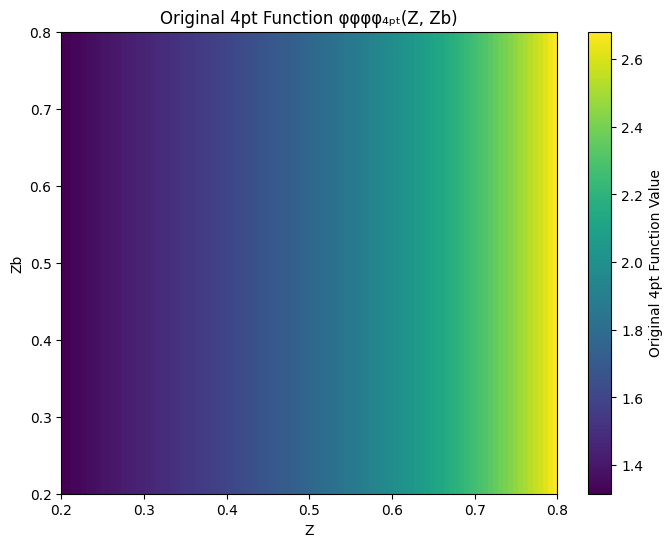

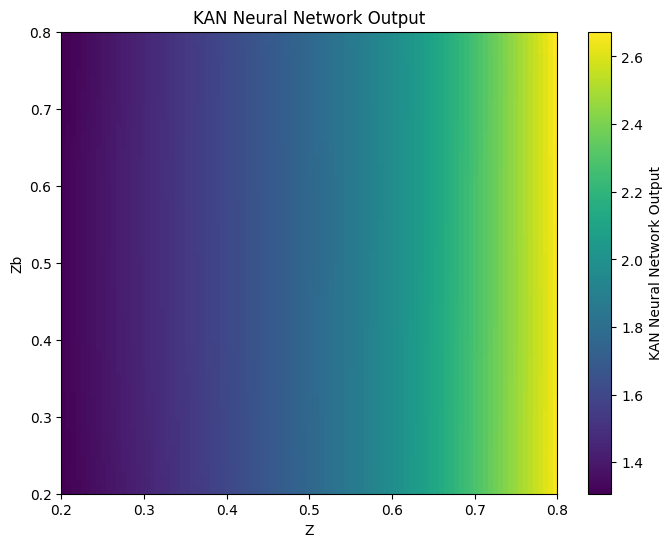

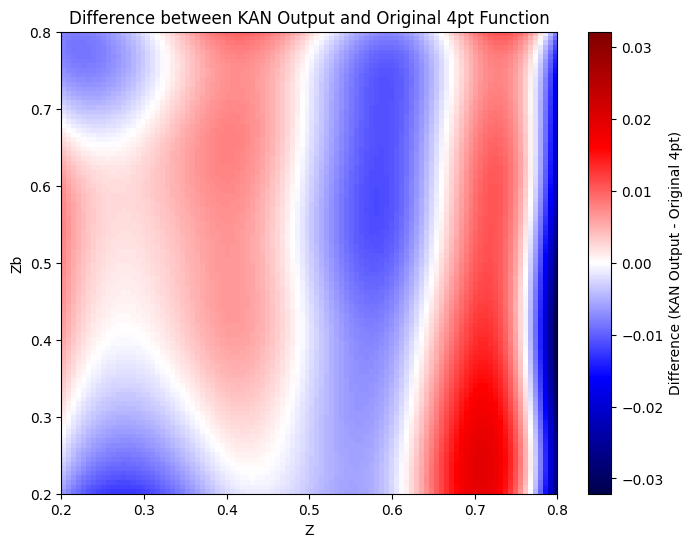

In [302]:
# Assuming the necessary imports and variables from previous code are already in place
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the grid for plotting
grid_size = 100
Z_plot = np.linspace(0.2, .8, grid_size)
Zb_plot = np.linspace(.2, .8, grid_size)
Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
Z_flat = Z_grid.flatten()
Zb_flat = Zb_grid.flatten()

# Convert grid points to tensors
Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device).unsqueeze(1)
Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device).unsqueeze(1)

# Evaluate the original 4pt function on the grid
phi4pt_values = phi4pt_func(Z_flat, Zb_flat)
phi4pt_grid = phi4pt_values.reshape(grid_size, grid_size)

# Evaluate the KAN model output on the grid
with torch.no_grad():
    inputs_plot = torch.cat([Z_tensor, Zb_tensor], dim=1)
    outputs_plot = model(inputs_plot).cpu().numpy().flatten()
outputs_plot_grid = outputs_plot.reshape(grid_size, grid_size)

# Compute the difference between the KAN output and the original 4pt function
difference_grid = outputs_plot_grid - phi4pt_grid

# Plot the original 4pt function
plt.figure(figsize=(8, 6))
plt.imshow(phi4pt_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Original 4pt Function Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Original 4pt Function φφφφ₄ₚₜ(Z, Zb)')
plt.show()

# Plot the KAN Neural Network Output
plt.figure(figsize=(8, 6))
plt.imshow(outputs_plot_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='KAN Neural Network Output')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('KAN Neural Network Output')
plt.show()

# Plot the Difference between KAN Output and Original 4pt Function
plt.figure(figsize=(8, 6))
plt.imshow(difference_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='seismic', 
           vmin=-np.max(np.abs(difference_grid)), vmax=np.max(np.abs(difference_grid)))
plt.colorbar(label='Difference (KAN Output - Original 4pt)')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Difference between KAN Output and Original 4pt Function')
plt.show()


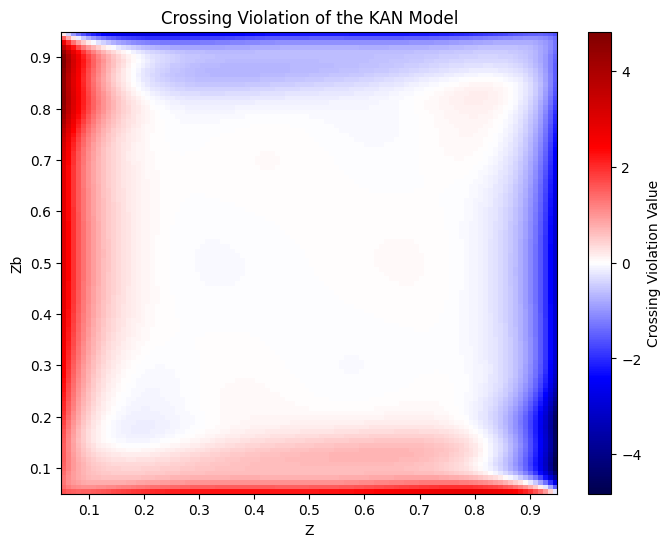

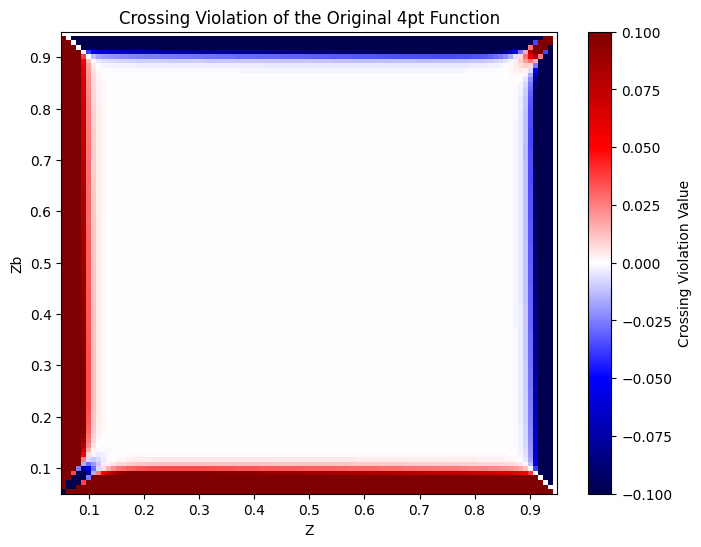

In [271]:
grid_size = 100
Z_plot = np.linspace(0.05, 0.95, grid_size)
Zb_plot = np.linspace(0.05, 0.95, grid_size)
Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
Z_flat = Z_grid.flatten()
Zb_flat = Zb_grid.flatten()

# Convert grid points to tensors
Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device).unsqueeze(1)
Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device).unsqueeze(1)

# Define phi_func to use the KAN model for predictions
def phi_func(Z, Zb):
    Z_tensor = torch.tensor(Z, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb, dtype=torch.float32, device=device).unsqueeze(1)
    inputs = torch.cat([Z_tensor, Zb_tensor], dim=1)
    with torch.no_grad():
        phi_values = model(inputs).cpu().numpy().flatten()
    return phi_values

# Compute the crossing equation values using the KAN model
epsilon = 1e-8  # Small constant to prevent division by zero
Z_np_clamped = np.clip(Z_flat, epsilon, 1 - epsilon)
Zb_np_clamped = np.clip(Zb_flat, epsilon, 1 - epsilon)

# Calculate the crossing violation
crossing_values = crossing_equation(Z_np_clamped, Zb_np_clamped, phi_func)

# Reshape crossing values for plotting
crossing_values_grid = crossing_values.reshape(grid_size, grid_size)

# Plot the crossing violation
plt.figure(figsize=(8, 6))
max_abs_crossing = np.max(np.abs(crossing_values))
plt.imshow(crossing_values_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
           vmin=-max_abs_crossing, vmax=max_abs_crossing)
plt.colorbar(label='Crossing Violation Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Crossing Violation of the KAN Model')
plt.show()

crossing_values = crossing_equation(Z_clamped, Zb_clamped, phi4pt_func)

# Reshape crossing values for plotting
crossing_values_grid = crossing_values.reshape(grid_size, grid_size)

# Plot the crossing violation
plt.figure(figsize=(8, 6))
max_abs_crossing = np.nanmax(np.abs(crossing_values))
plt.imshow(crossing_values_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
           vmin=-max_abs_crossing, vmax=max_abs_crossing)
plt.colorbar(label='Crossing Violation Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Crossing Violation of the Original 4pt Function')
plt.show()

In [196]:
train(model,1000,1.0,0.05)

Training:   0%|          | 1/1000 [00:00<04:34,  3.65it/s]

Epoch 0: Total Loss = 0.001253, Loss A = 0.000280, Loss B = 0.019457


Training:  10%|█         | 101/1000 [00:30<05:38,  2.66it/s]

Epoch 100: Total Loss = 0.001085, Loss A = 0.000311, Loss B = 0.015477


Training:  20%|██        | 201/1000 [00:55<03:19,  4.01it/s]

Epoch 200: Total Loss = 0.001003, Loss A = 0.000304, Loss B = 0.013987


Training:  30%|███       | 301/1000 [01:22<03:02,  3.82it/s]

Epoch 300: Total Loss = 0.000940, Loss A = 0.000294, Loss B = 0.012918


Training:  40%|████      | 401/1000 [01:49<02:32,  3.92it/s]

Epoch 400: Total Loss = 0.000888, Loss A = 0.000284, Loss B = 0.012084


Training:  50%|█████     | 501/1000 [02:16<02:03,  4.03it/s]

Epoch 500: Total Loss = 0.000845, Loss A = 0.000274, Loss B = 0.011404


Training:  60%|██████    | 601/1000 [02:45<01:36,  4.15it/s]

Epoch 600: Total Loss = 0.000807, Loss A = 0.000266, Loss B = 0.010835


Training:  70%|███████   | 701/1000 [03:10<01:07,  4.40it/s]

Epoch 700: Total Loss = 0.000775, Loss A = 0.000258, Loss B = 0.010346


Training:  80%|████████  | 801/1000 [03:35<00:45,  4.38it/s]

Epoch 800: Total Loss = 0.000746, Loss A = 0.000250, Loss B = 0.009917


Training:  90%|█████████ | 901/1000 [04:00<00:23,  4.20it/s]

Epoch 900: Total Loss = 0.000719, Loss A = 0.000243, Loss B = 0.009532


Training: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]


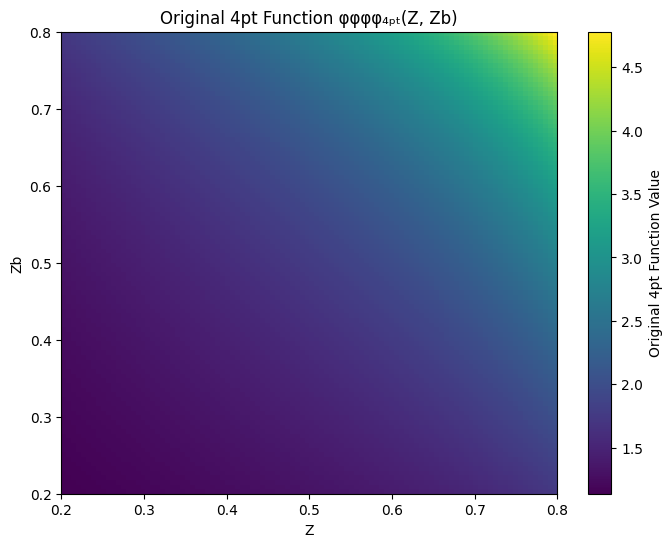

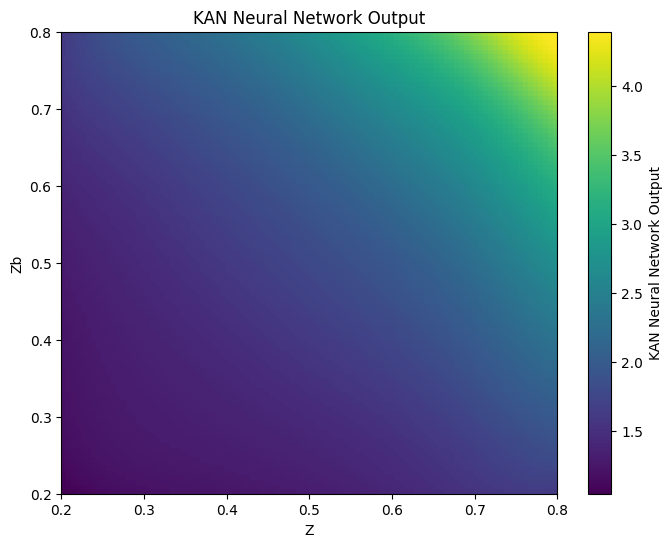

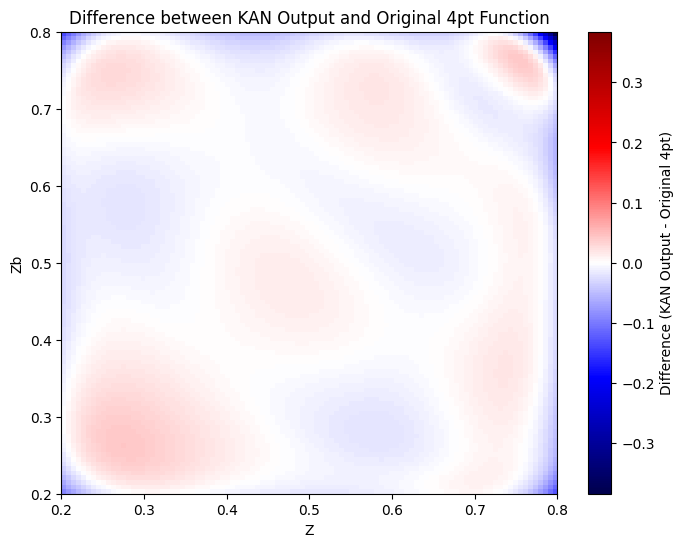

In [197]:
# Assuming the necessary imports and variables from previous code are already in place
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the grid for plotting
grid_size = 100
Z_plot = np.linspace(0.2, .8, grid_size)
Zb_plot = np.linspace(.2, .8, grid_size)
Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
Z_flat = Z_grid.flatten()
Zb_flat = Zb_grid.flatten()

# Convert grid points to tensors
Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device).unsqueeze(1)
Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device).unsqueeze(1)

# Evaluate the original 4pt function on the grid
phi4pt_values = phi4pt_func(Z_flat, Zb_flat)
phi4pt_grid = phi4pt_values.reshape(grid_size, grid_size)

# Evaluate the KAN model output on the grid
with torch.no_grad():
    inputs_plot = torch.cat([Z_tensor, Zb_tensor], dim=1)
    outputs_plot = model(inputs_plot).cpu().numpy().flatten()
outputs_plot_grid = outputs_plot.reshape(grid_size, grid_size)

# Compute the difference between the KAN output and the original 4pt function
difference_grid = outputs_plot_grid - phi4pt_grid

# Plot the original 4pt function
plt.figure(figsize=(8, 6))
plt.imshow(phi4pt_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Original 4pt Function Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Original 4pt Function φφφφ₄ₚₜ(Z, Zb)')
plt.show()

# Plot the KAN Neural Network Output
plt.figure(figsize=(8, 6))
plt.imshow(outputs_plot_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='KAN Neural Network Output')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('KAN Neural Network Output')
plt.show()

# Plot the Difference between KAN Output and Original 4pt Function
plt.figure(figsize=(8, 6))
plt.imshow(difference_grid, extent=[.2, .8, 0.2, .8], origin='lower', aspect='auto', cmap='seismic', 
           vmin=-np.max(np.abs(difference_grid)), vmax=np.max(np.abs(difference_grid)))
plt.colorbar(label='Difference (KAN Output - Original 4pt)')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Difference between KAN Output and Original 4pt Function')
plt.show()


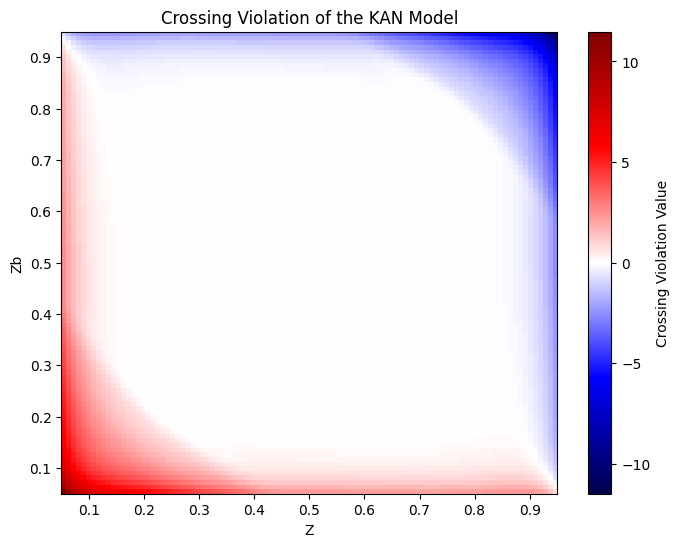

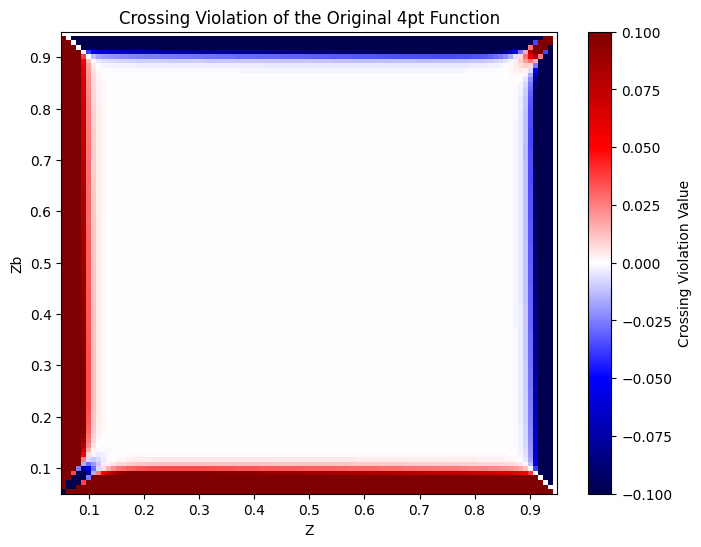

In [258]:
grid_size = 100
Z_plot = np.linspace(0.05, 0.95, grid_size)
Zb_plot = np.linspace(0.05, 0.95, grid_size)
Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
Z_flat = Z_grid.flatten()
Zb_flat = Zb_grid.flatten()

# Convert grid points to tensors
Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device).unsqueeze(1)
Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device).unsqueeze(1)

# Define phi_func to use the KAN model for predictions
def phi_func(Z, Zb):
    Z_tensor = torch.tensor(Z, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb, dtype=torch.float32, device=device).unsqueeze(1)
    inputs = torch.cat([Z_tensor, Zb_tensor], dim=1)
    with torch.no_grad():
        phi_values = model(inputs).cpu().numpy().flatten()
    return phi_values

# Compute the crossing equation values using the KAN model
epsilon = 1e-8  # Small constant to prevent division by zero
Z_np_clamped = np.clip(Z_flat, epsilon, 1 - epsilon)
Zb_np_clamped = np.clip(Zb_flat, epsilon, 1 - epsilon)

# Calculate the crossing violation
crossing_values = crossing_equation(Z_np_clamped, Zb_np_clamped, phi_func)

# Reshape crossing values for plotting
crossing_values_grid = crossing_values.reshape(grid_size, grid_size)

# Plot the crossing violation
plt.figure(figsize=(8, 6))
max_abs_crossing = np.max(np.abs(crossing_values))
plt.imshow(crossing_values_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
           vmin=-max_abs_crossing, vmax=max_abs_crossing)
plt.colorbar(label='Crossing Violation Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Crossing Violation of the KAN Model')
plt.show()

crossing_values = crossing_equation(Z_clamped, Zb_clamped, phi4pt_func)

# Reshape crossing values for plotting
crossing_values_grid = crossing_values.reshape(grid_size, grid_size)

# Plot the crossing violation
plt.figure(figsize=(8, 6))
max_abs_crossing = np.nanmax(np.abs(crossing_values))
plt.imshow(crossing_values_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
           vmin=-max_abs_crossing, vmax=max_abs_crossing)
plt.colorbar(label='Crossing Violation Value')
plt.xlabel('Z')
plt.ylabel('Zb')
plt.title('Crossing Violation of the Original 4pt Function')
plt.show()

In [233]:
model(torch.tensor([[1/2,1/2]]))

tensor([[1.7818]], grad_fn=<AddBackward0>)

In [234]:
phi_func([1/2], [1/2])

array([1.7818209], dtype=float32)

In [311]:
import torch
import torch.nn as nn
import numpy as np
import sympy as sp
from tqdm import tqdm

# Import KAN module (assuming it's available)
from kan import KAN  # Ensure that 'kan' is installed or available in your PYTHONPATH

def read_phi4pt_function(file_path):
    """
    Reads and preprocesses the 4pt function from a file.

    Args:
        file_path (str): Path to the 4pt function file.

    Returns:
        function: A numerical function of Z and Zb.
    """
    with open(file_path, 'r') as f:
        expr_str = f.read()
    expr_str = expr_str.replace('*^', 'e')
    expr_str = expr_str.replace('^', '**')
    expr_str = expr_str.replace('\n', ' ')
    Z_sym, Zb_sym = sp.symbols('Z Zb')
    expr = sp.sympify(expr_str, locals={'Z': Z_sym, 'Zb': Zb_sym})
    phi4pt_func = sp.lambdify((Z_sym, Zb_sym), expr, modules='numpy')
    return phi4pt_func

def crossing_equation(Z, Zb, phi_func, Delta_phi):
    term1 = (Z * Zb) ** (-Delta_phi) * phi_func(Z, Zb)
    term2 = ((1 - Z) * (1 - Zb)) ** (-Delta_phi) * phi_func(1 - Z, 1 - Zb)
    return term1 - term2

def loss_region_a(model_output, target_output):
    return torch.mean((model_output - target_output) ** 2)

def loss_region_b(crossing_values):
    return torch.mean(crossing_values ** 2)

def total_loss(model, Z_a, Zb_a, phi4pt_a, Z_b, Zb_b, Delta_phi, weight_a, weight_b):
    # Predictions in Region A
    inputs_a = torch.cat([Z_a, Zb_a], dim=1)
    outputs_a = model(inputs_a)
    loss_a = loss_region_a(outputs_a, phi4pt_a)

    # Predictions in Region B
    inputs_b = torch.cat([Z_b, Zb_b], dim=1)
    outputs_b = model(inputs_b)

    # Compute crossing equation values for outputs_b
    phi_func_model = lambda Z, Zb: model(torch.cat([Z, Zb], dim=1))
    crossing_b = crossing_equation(Z_b, Zb_b, phi_func_model, Delta_phi)
    loss_b = loss_region_b(crossing_b)

    # Total loss
    return weight_a * loss_a + weight_b * loss_b, loss_a, loss_b

def train_kan(file_path, Delta_phi, num_points, model=None, num_epochs=10000, weight_a=1.0, weight_b=1.0, width=[2,8,1], grid=10, k=3, seed=1, device=None):
    """
    Trains the KAN network.

    Args:
        file_path (str): Path to the 4pt function file.
        Delta_phi (float): Scaling dimension.
        num_points (int): Number of random points to generate.
        model (KAN, optional): Existing KAN model to train. If None, a new model is created.
        num_epochs (int, optional): Number of training epochs. Defaults to 10000.
        weight_a (float, optional): Weight for Region A loss. Defaults to 1.0.
        weight_b (float, optional): Weight for Region B loss. Defaults to 1.0.
        width (list, optional): Width of the KAN network layers. Defaults to [2,8,1].
        grid (int, optional): Grid parameter for KAN. Defaults to 10.
        k (int, optional): K parameter for KAN. Defaults to 3.
        seed (int, optional): Seed for KAN. Defaults to 1.
        device (torch.device, optional): Device to use. Defaults to None.

    Returns:
        model: Trained KAN model.
        function: The original 4pt function for plotting.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Using device: {device}')

    # Read the 4pt function
    phi4pt_func = read_phi4pt_function(file_path)

    # Generate random points in [0, 1] x [0, 1]
    Z_vals = np.random.uniform(0, 1, num_points)
    Zb_vals = np.random.uniform(0, 1, num_points)
    points = np.vstack((Z_vals, Zb_vals)).T

    # Define Region A: Z and Zb between 0.2 and 0.8
    mask_region_a = (Z_vals >= 0.2) & (Z_vals <= 0.8) & (Zb_vals >= 0.2) & (Zb_vals <= 0.8)
    mask_region_b = ~mask_region_a  # Points outside Region A

    # Points in Region A
    points_a = points[mask_region_a]
    Z_a = points_a[:, 0]
    Zb_a = points_a[:, 1]

    # Points in Region B
    points_b = points[mask_region_b]
    Z_b = points_b[:, 0]
    Zb_b = points_b[:, 1]

    # Convert to torch tensors
    Z_a_tensor = torch.tensor(Z_a, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_a_tensor = torch.tensor(Zb_a, dtype=torch.float32, device=device).unsqueeze(1)
    Z_b_tensor = torch.tensor(Z_b, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_b_tensor = torch.tensor(Zb_b, dtype=torch.float32, device=device).unsqueeze(1)

    # Compute the 4pt function values at points in Region A
    phi4pt_a = phi4pt_func(Z_a, Zb_a)
    phi4pt_a_tensor = torch.tensor(phi4pt_a, dtype=torch.float32, device=device).unsqueeze(1)

    # Initialize the model if not provided
    if model is None:
        model = KAN(width=width, grid=grid, k=k, seed=seed, device=device).to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in tqdm(range(num_epochs), desc='Training'):
        optimizer.zero_grad()

        # Compute total loss
        loss_total, loss_a_value, loss_b_value = total_loss(
            model,
            Z_a_tensor, Zb_a_tensor, phi4pt_a_tensor,
            Z_b_tensor, Zb_b_tensor,
            Delta_phi,
            weight_a, weight_b
        )

        # Backpropagation
        loss_total.backward()
        optimizer.step()

        # Print losses every (num_epochs/10) epochs
        if epoch % max(int(num_epochs/10),1) == 0:
            print(f'Epoch {epoch}: Total Loss = {loss_total.item():.6f}, '
                  f'Loss A = {loss_a_value.item():.6f}, Loss B = {loss_b_value.item():.6f}')

    # Return the trained model and the phi4pt_func for plotting
    return model, phi4pt_func

def plot_results(model, phi4pt_func, device, grid_size=100):
    """
    Plots the original 4pt function, the KAN network's output, and their difference.

    Args:
        model: Trained KAN model.
        phi4pt_func (function): The original 4pt function.
        device (torch.device): Device to use.
        grid_size (int, optional): Grid size for plotting. Defaults to 100.
    """
    import matplotlib.pyplot as plt

    # Define the grid for plotting
    Z_plot = np.linspace(0.2, 0.8, grid_size)
    Zb_plot = np.linspace(0.2, 0.8, grid_size)
    Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
    Z_flat = Z_grid.flatten()
    Zb_flat = Zb_grid.flatten()

    # Convert grid points to tensors
    Z_tensor = torch.tensor(Z_flat, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb_flat, dtype=torch.float32, device=device).unsqueeze(1)

    # Evaluate the original 4pt function on the grid
    phi4pt_values = phi4pt_func(Z_flat, Zb_flat)
    phi4pt_grid = phi4pt_values.reshape(grid_size, grid_size)

    # Evaluate the KAN model output on the grid
    with torch.no_grad():
        inputs_plot = torch.cat([Z_tensor, Zb_tensor], dim=1)
        outputs_plot = model(inputs_plot).cpu().numpy().flatten()
    outputs_plot_grid = outputs_plot.reshape(grid_size, grid_size)

    # Compute the difference between the KAN output and the original 4pt function
    difference_grid = outputs_plot_grid - phi4pt_grid

    # Plot the original 4pt function
    plt.figure(figsize=(8, 6))
    plt.imshow(phi4pt_grid, extent=[0.2, 0.8, 0.2, 0.8], origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Original 4pt Function Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Original 4pt Function φφφφ₄ₚₜ(Z, Zb)')
    plt.show()

    # Plot the KAN Neural Network Output
    plt.figure(figsize=(8, 6))
    plt.imshow(outputs_plot_grid, extent=[0.2, 0.8, 0.2, 0.8], origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='KAN Neural Network Output')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('KAN Neural Network Output')
    plt.show()

    # Plot the Difference between KAN Output and Original 4pt Function
    plt.figure(figsize=(8, 6))
    plt.imshow(difference_grid, extent=[0.2, 0.8, 0.2, 0.8], origin='lower', aspect='auto', cmap='seismic',
               vmin=-np.max(np.abs(difference_grid)), vmax=np.max(np.abs(difference_grid)))
    plt.colorbar(label='Difference (KAN Output - Original 4pt)')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Difference between KAN Output and Original 4pt Function')
    plt.show()


    

In [317]:
def plot_crossing_violation(model, phi4pt_func, Delta_phi, device, grid_size=100):
    """
    Plots the crossing violation of both the KAN model and the original 4pt function.

    Args:
        model: Trained KAN model.
        phi4pt_func (function): The original 4pt function.
        Delta_phi (float): Scaling dimension.
        device (torch.device): Device to use.
        grid_size (int, optional): Grid size for plotting. Defaults to 100.
    """
    import matplotlib.pyplot as plt

    # Define the grid for plotting
    Z_plot = np.linspace(0.05, 0.95, grid_size)
    Zb_plot = np.linspace(0.05, 0.95, grid_size)
    Z_grid, Zb_grid = np.meshgrid(Z_plot, Zb_plot)
    Z_flat = Z_grid.flatten()
    Zb_flat = Zb_grid.flatten()

    # Clamping to avoid division by zero
    epsilon = 1e-8  # Small constant to prevent division by zero
    Z_clamped = np.clip(Z_flat, epsilon, 1 - epsilon)
    Zb_clamped = np.clip(Zb_flat, epsilon, 1 - epsilon)

    # Convert grid points to tensors
    Z_tensor = torch.tensor(Z_clamped, dtype=torch.float32, device=device).unsqueeze(1)
    Zb_tensor = torch.tensor(Zb_clamped, dtype=torch.float32, device=device).unsqueeze(1)

    # Define phi_func to use the KAN model for predictions
    def phi_func_model(Z, Zb):
        Z_tensor = torch.tensor(Z, dtype=torch.float32, device=device).unsqueeze(1)
        Zb_tensor = torch.tensor(Zb, dtype=torch.float32, device=device).unsqueeze(1)
        inputs = torch.cat([Z_tensor, Zb_tensor], dim=1)
        with torch.no_grad():
            phi_values = model(inputs).cpu().numpy().flatten()
        return phi_values

    # Compute the crossing equation values using the KAN model
    crossing_values_model = crossing_equation(Z_clamped, Zb_clamped, phi_func_model, Delta_phi)
    crossing_values_model_grid = crossing_values_model.reshape(grid_size, grid_size)

    # Plot the crossing violation of the KAN model
    plt.figure(figsize=(8, 6))
    max_abs_crossing = np.max(np.abs(crossing_values_model))
    plt.imshow(crossing_values_model_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
               vmin=-max_abs_crossing, vmax=max_abs_crossing)
    plt.colorbar(label='Crossing Violation Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Crossing Violation of the KAN Model')
    plt.show()

    # Compute the crossing equation values using the original 4pt function
    crossing_values_phi4pt = crossing_equation(Z_clamped, Zb_clamped, phi4pt_func, Delta_phi)
    crossing_values_phi4pt_grid = crossing_values_phi4pt.reshape(grid_size, grid_size)

    # Plot the crossing violation of the original 4pt function
    plt.figure(figsize=(8, 6))
    max_abs_crossing_phi4pt = np.nanmax(np.abs(crossing_values_phi4pt))
    plt.imshow(crossing_values_phi4pt_grid, extent=[0.05, 0.95, 0.05, 0.95], origin='lower', aspect='auto', cmap='seismic',
               vmin=-max_abs_crossing_phi4pt, vmax=max_abs_crossing_phi4pt)
    plt.colorbar(label='Crossing Violation Value')
    plt.xlabel('Z')
    plt.ylabel('Zb')
    plt.title('Crossing Violation of the Original 4pt Function')
    plt.show()

In [ ]:
file_path = 'test_fn.txt'  # Replace with your file path
Delta_phi = 0.5181489  # Adjust as needed
num_points = 1000
num_epochs = 100

    # Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize the KAN model (once)
model = KAN(width=[2,8,1], grid=10, k=3, seed=1, device=device).to(device)
    # Train the model


Training:   3%|▎         | 3/100 [00:00<00:09, 10.10it/s]

Epoch 0: Total Loss = 0.000301, Loss A = 0.000301, Loss B = 234.364792


Training:  13%|█▎        | 13/100 [00:01<00:06, 13.78it/s]

Epoch 10: Total Loss = 0.000275, Loss A = 0.000275, Loss B = 241.922592


Training:  23%|██▎       | 23/100 [00:01<00:06, 11.58it/s]

Epoch 20: Total Loss = 0.000210, Loss A = 0.000210, Loss B = 246.264511


Training:  31%|███       | 31/100 [00:02<00:05, 11.95it/s]

Epoch 30: Total Loss = 0.000156, Loss A = 0.000156, Loss B = 252.863876


Training:  42%|████▏     | 42/100 [00:04<00:05, 10.48it/s]

Epoch 40: Total Loss = 0.000115, Loss A = 0.000115, Loss B = 259.328796


Training:  52%|█████▏    | 52/100 [00:04<00:03, 13.30it/s]

Epoch 50: Total Loss = 0.000086, Loss A = 0.000086, Loss B = 266.172791


Training:  62%|██████▏   | 62/100 [00:05<00:02, 13.33it/s]

Epoch 60: Total Loss = 0.000066, Loss A = 0.000066, Loss B = 271.460388


Training:  72%|███████▏  | 72/100 [00:06<00:02, 13.96it/s]

Epoch 70: Total Loss = 0.000051, Loss A = 0.000051, Loss B = 275.092957


Training:  82%|████████▏ | 82/100 [00:06<00:01, 13.77it/s]

Epoch 80: Total Loss = 0.000040, Loss A = 0.000040, Loss B = 277.103729


Training:  92%|█████████▏| 92/100 [00:07<00:00, 13.76it/s]

Epoch 90: Total Loss = 0.000032, Loss A = 0.000032, Loss B = 277.758057


Training: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


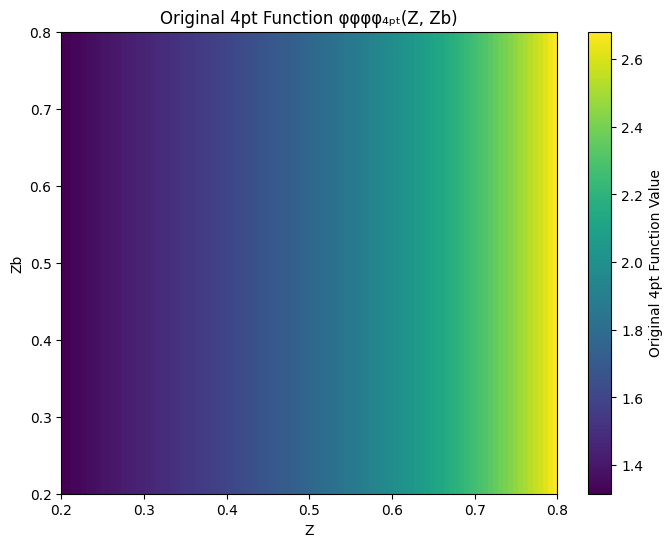

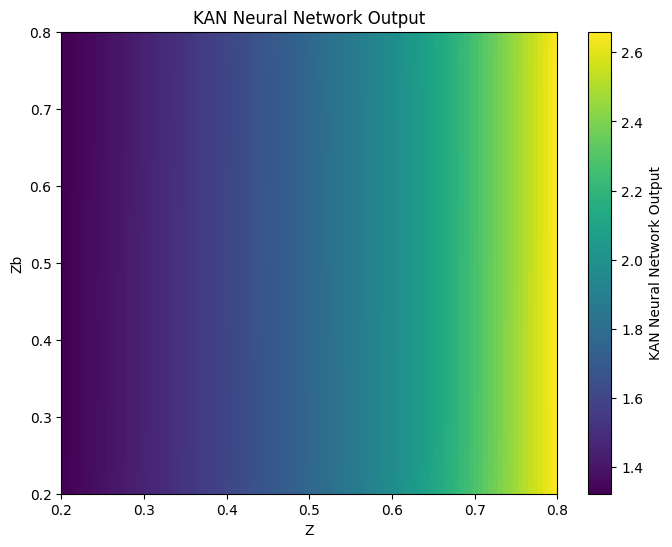

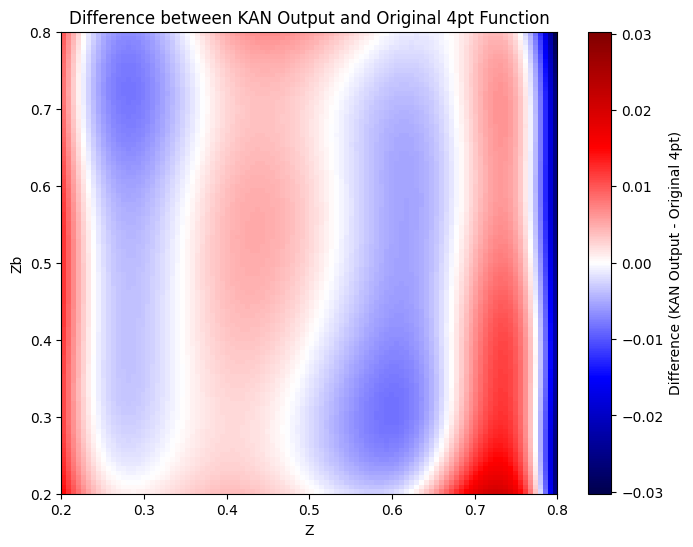

In [316]:
model, phi4pt_func = train_kan(
        file_path, Delta_phi, num_points, model=model,
        num_epochs=num_epochs, weight_a=1.0, weight_b=0.0, device=device
    )



    # Plot results
plot_results(model, phi4pt_func, device)

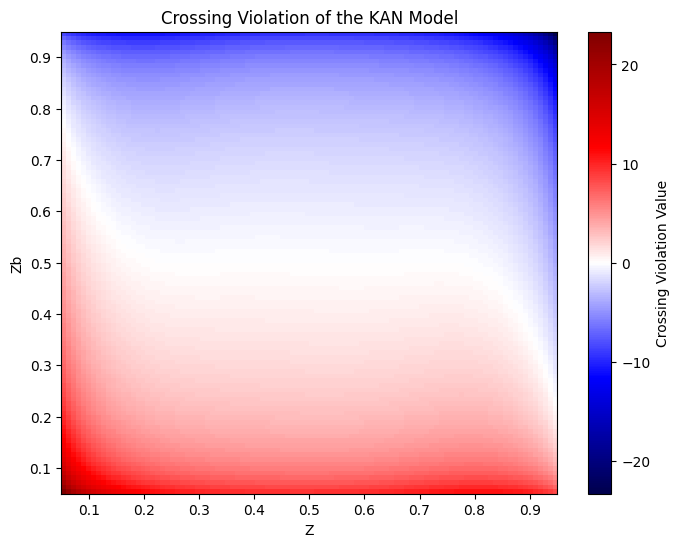

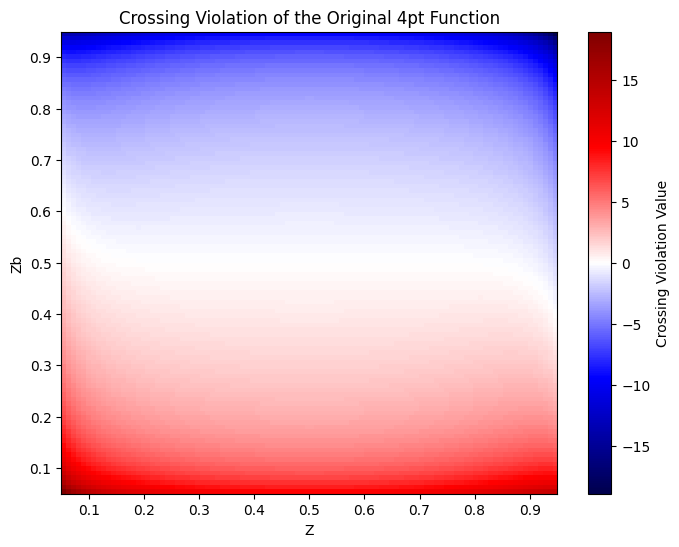

In [318]:
plot_crossing_violation(model, phi4pt_func, Delta_phi, device)
